In [1]:
import warnings
from pathlib import Path

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

warnings.filterwarnings('ignore', category=UserWarning)

In [2]:
def fmt(s):
    try:
        n = f"{float(s):.3f}"
    except:
        n = ""
    return n

#### Create configs for loading evalzoo results

In [3]:
results_dir = Path("../2.evalzoo/results/")
mertrics_filename = "metrics_level_1_ref"

metrics_columns = {
    "sim_retrieval_average_precision_ref_i_mean_i": "mAP",
    "sim_retrieval_average_precision_ref_i_nlog10pvalue_mean_i": "-log(pvalue)",
    "sim_retrieval_average_precision_ref_i_nlog10qvalue_mean_i": "-log(qvalue)",
}

metrics = {
    # subset -> robustMAD -> feature select -> metrics
    "subset\t\t": {
        "same_well_diff_pert": "0e4cd68f",
        "same_pert_diff_well": "ceb5f02a",
        "same_well_same_pert": "34fbd8a4",
    },
    # subset -> correct -> robustMAD -> feature select -> metrics
    "subset->correct\t": {
        "same_well_diff_pert": "82ad004e",
        "same_pert_diff_well": "f5c36cb4",
        "same_well_same_pert": "d66f1bce",
    },
    # correct -> robustMAD -> feature select -> subset -> metrics
    "correct->subset\t": {
        "same_well_diff_pert": "3ec971b2",
        "same_pert_diff_well": "72f94e10",
        "same_well_same_pert": "138739c0",
    },
    
}

groupby_columns = {
    "same_well_diff_pert": ["Metadata_Well"],
    "same_pert_diff_well": ["Metadata_JCP2022"],
    "same_well_same_pert": ["Metadata_Well", "Metadata_JCP2022"],
}

#### Load evalzoo metrics

In [4]:
metrics_dfs = []

for subset, configs in metrics.items():
    for config, config_dir in configs.items():
        metric_cols = list(metrics_columns.keys())
        metrics_path = results_dir / config_dir / f"{mertrics_filename}.parquet"
        metrics_df = pd.read_parquet(metrics_path, columns=metric_cols + groupby_columns[config])
        metrics_df = metrics_df.groupby(groupby_columns[config])[metric_cols].mean().reset_index()
        metrics_df.drop(groupby_columns[config], axis=1, inplace=True)
        metrics_df.rename(columns=metrics_columns, inplace=True)
        metrics_df["config"] = config
        metrics_df["subset"] = subset
        metrics_df["p<0.05"] = metrics_df["-log(pvalue)"] > 1.3
        metrics_dfs.append(metrics_df)

In [5]:
metrics_df = pd.concat(metrics_dfs, axis=0)
metrics_df.shape

(12174, 6)

#### Plot mAP scatterplots and densities

same_well_diff_pert subset		 mmAP: 0.0634 p<0.05: 0.139 (51/368)
same_well_diff_pert subset->correct	 mmAP: 0.0594 p<0.05: 0.0353 (13/368)
same_well_diff_pert correct->subset	 mmAP: 0.0978 p<0.05: 0.166 (61/368)


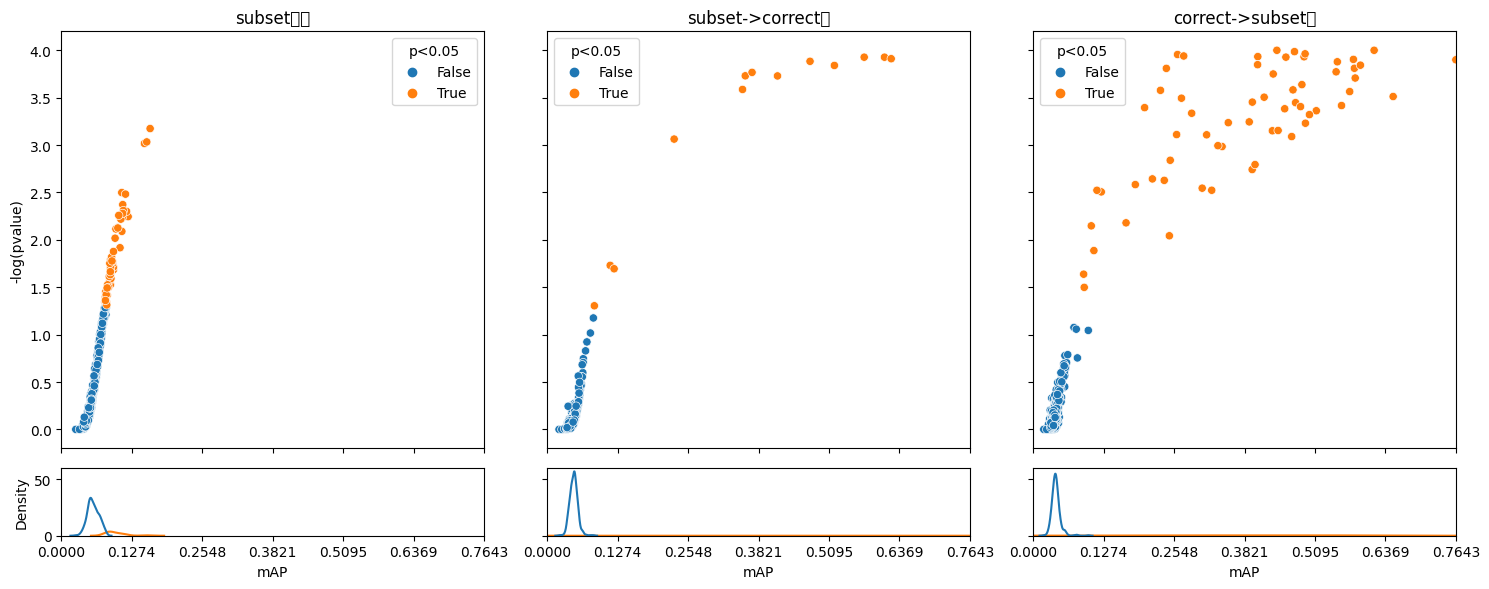

same_pert_diff_well subset		 mmAP: 0.00961 p<0.05: 0.0 (0/37)
same_pert_diff_well subset->correct	 mmAP: 0.0135 p<0.05: 0.0 (0/37)
same_pert_diff_well correct->subset	 mmAP: 0.0102 p<0.05: 0.027 (1/37)


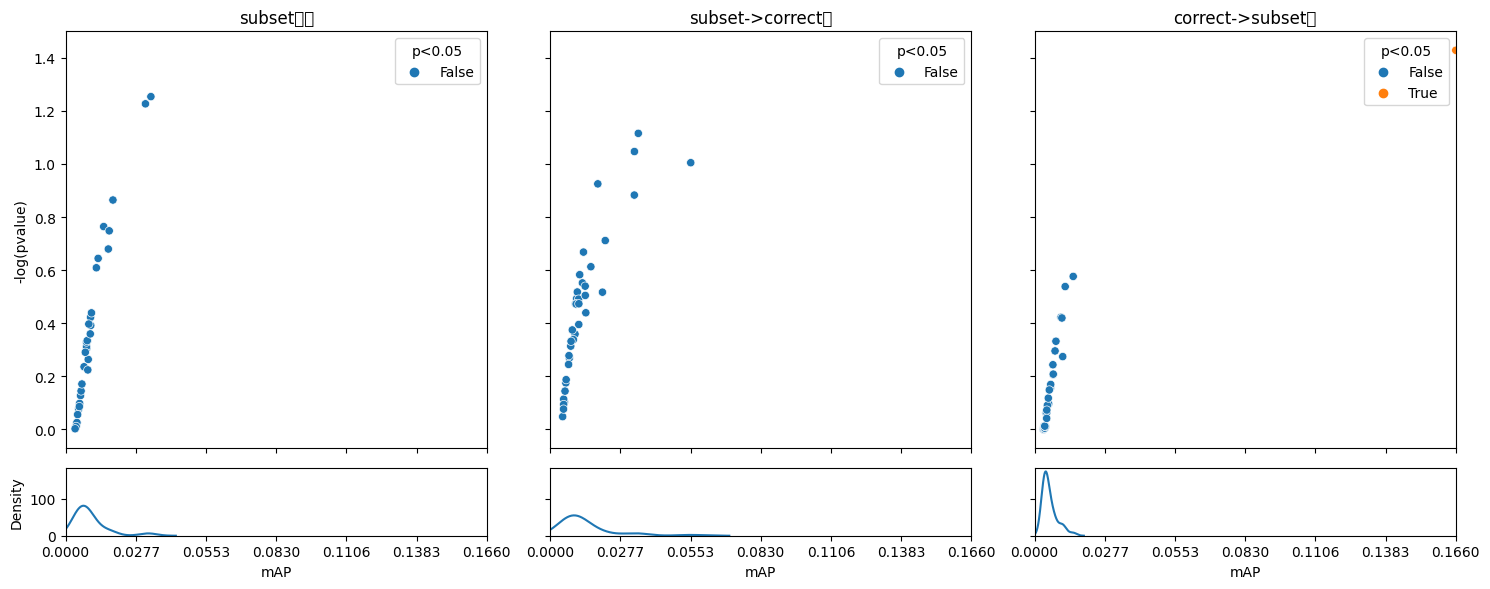

same_well_same_pert subset		 mmAP: 0.197 p<0.05: 0.902 (3295/3653)
same_well_same_pert subset->correct	 mmAP: 0.165 p<0.05: 0.775 (2831/3653)
same_well_same_pert correct->subset	 mmAP: 0.243 p<0.05: 0.684 (2499/3653)


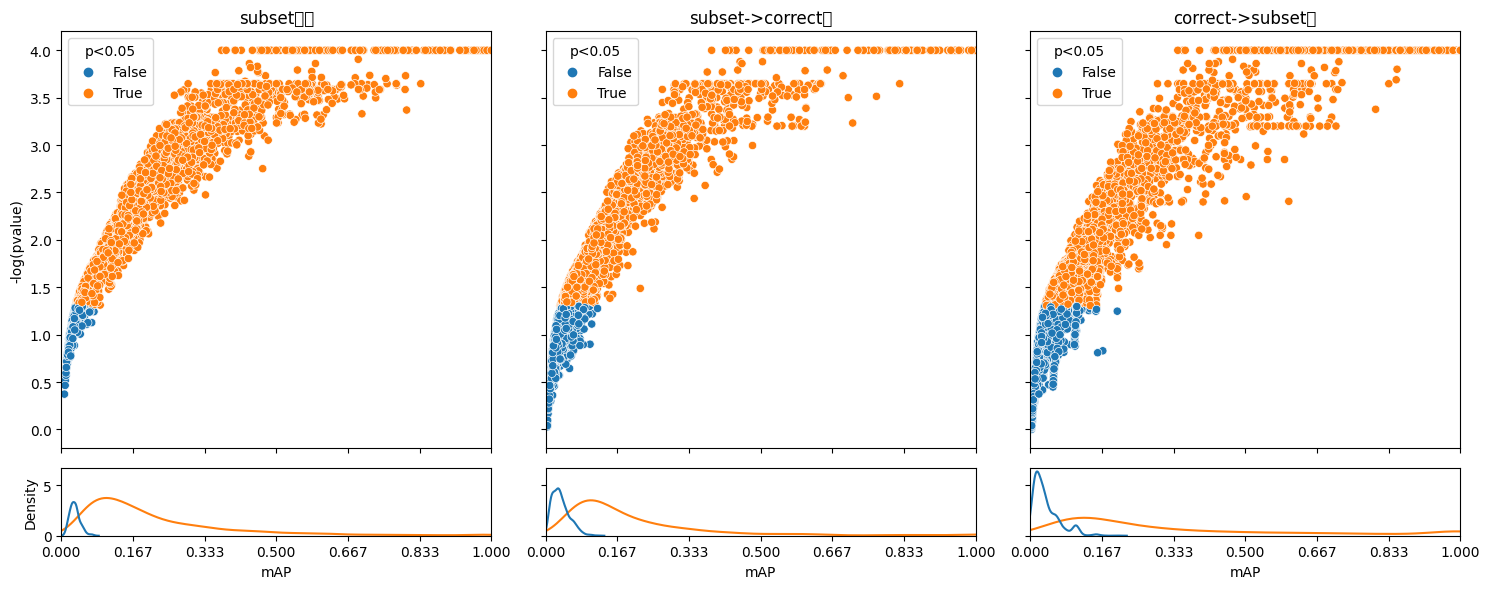

In [6]:
def scatterplot(x, y, hue, **kwargs):
    ax = plt.gca()
    sns.scatterplot(x=x, y=y, hue=hue, ax=ax, **kwargs)

def kdeplot(x, y, hue, **kwargs):
    ax = plt.gca()
    sns.kdeplot(x=x, y=y, hue=hue ,ax=ax, **kwargs)

def remove_inner_ticklabels(fig):
    for ax in fig.axes:
        try:
            ax.label_outer()
        except:
            pass

for config in metrics_df.config.unique():
    config_df = metrics_df[metrics_df.config==config]

    subsets = config_df['subset'].unique()
    n_subsets = len(subsets)

    fig = plt.figure(figsize=(n_subsets * 5, 6))

    # Create a custom GridSpec
    gs = fig.add_gridspec(6, n_subsets)
    scatter_axes = [None] * n_subsets
    kde_axes = [None] * n_subsets

    for i in range(n_subsets):
        scatter_axes[i] = fig.add_subplot(gs[:5, i], sharex=None if i == 0 else scatter_axes[0], sharey=None if i == 0 else scatter_axes[0])
        kde_axes[i] = fig.add_subplot(gs[5, i], sharex=scatter_axes[i], sharey=None if i == 0 else kde_axes[0])

    for i, subset in enumerate(subsets):
        subset_df = config_df[config_df['subset'] == subset]
        p_value = subset_df['p<0.05']
        print(
            config,
            subset,
            f"mmAP: {subset_df.mAP.mean():.03}",
            f"p<0.05: {p_value.mean():.03} ({p_value.sum()}/{p_value.shape[0]})",
            )

        ax_scatter = scatter_axes[i]
        ax_kde = kde_axes[i]

        sns.scatterplot(data=subset_df, x="mAP", y="-log(pvalue)", hue="p<0.05", ax=ax_scatter)
        sns.kdeplot(data=subset_df, x="mAP", hue="p<0.05", ax=ax_kde, legend=False)
        
        ax_scatter.xaxis.set_major_locator(ticker.LinearLocator(7))
        ax_scatter.set_title(subset)
        
        # Set x-axis limits based on data range
        max_x = np.minimum(subset_df["mAP"].max(), 1)
        ax_scatter.set_xlim(0, max_x)
        
        if i > 0:
            ax_scatter.set_ylabel('')
            ax_kde.set_ylabel('')

    remove_inner_ticklabels(fig)
    plt.tight_layout()
    plt.show()